# Kubeflow test flakiness report
This notebook reports kubeflow test flakiness. We leverqe [kettle](https://github.com/kubernetes/test-infra/tree/master/kettle) which uploads test metadata into bigquery upon publishing in GCS buckets via [Prow](https://github.com/kubernetes/test-infra/tree/master/prow). Also we sligthly modify flakiness queries used in k8s infra-test [metrics](https://github.com/kubernetes/test-infra/tree/master/metrics) to compute daily flakiness metrics and job fields for kubeflow test jobs as follows:  

-  __job__: name of the test e.g., pr:kubeflow-presubmit (if a test is triggered by a pr, kettle adds "pr:" to the brgining of the job name.)
-  __start_date__: test start date
-  __runs__: total number of test runs during the day of the start date 
-  __flakes__: if different runs of a given commit report different result (some failed and some (one) passed), we say that flake happens for that commit. __flakes__ metric points to the number of flakes for all commits of the job dring the day (start date) 
-  __passed__: total number of times that the job runs sucessfully.  
-  __failed__: total number of distinct commits which do not have not any successfull run 
-  __flake_rate__: the ratio of number of flakes over the number of distinct commits
-  __commit_consistency__: one minus __flake_rate__
-  __build_consistency__: the ratio of useful runs over the total runs. If a job flakes then the last sucessful run is a useful run, otherwise all runs are useful. 
-  __flaky_runs__: __runs__ - __passed__ - __failed__




currently we compute the above for kubeflow prs which trigger presubmit tests. Later we will expand it for all types of kubeflow tests.

__Caveate__: flakiness metrics are correct for commits for which  a conclusion is made i.e., either it is passes or failed and is reflected in the logs. If a commit failed and future runs reveal that the failure was a flake, it wont be reflected in the current flakiness metrics. Therefore, we should look at flakiness report for a relatively long time (e.g., a week).    


In [31]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


# Compute daily flakiness of kubeflow presubmit tests

In [32]:
%%bigquery daily_flakiness
select 
    job,
    start_date,
    round(sum(if(flaked=1,passed,runs))/sum(runs),3) build_consistency,
    round(1-sum(flaked)/count(distinct commit),3) commit_consistency,
    round (sum(flaked)/count(distinct commit),3) flake_rate,
    sum(flaked) flakes,
    sum(runs) runs,
    sum(passed) passed,
    sum(flaky_runs) flaky_runs,
    sum(failed) failed
  from ( /* Determine whether a (job, pr-num, commit) flaked */
    select
      job,
      start_date,
      num,
      commit,
      if(passed = runs or passed = 0, 0, 1) flaked,
      if(passed = runs or passed = 0, 0, runs-passed) flaky_runs, 
      if(passed = 0, runs, 0) failed, 
      passed,
      CAST(runs as INT64) runs
    from (
      select /* Count the runs and passes for each (job, pr-num, commit) */
        max(start_date) start_date,
        num,
        commit,
        sum(if(result='SUCCESS',1,0)) passed,
        count(result) runs,
        job
      from (
        SELECT /* all runs of any job for the past week, noting the commit and whether it passed */
          job,
          regexp_extract(path, r'pull/(\d+)') as num, /* pr number */
          regexp_extract(m.value, r'[^,]+,\d+:([a-f0-9]+)"') commit, /* extract the first commit id from the repo flag */
          EXTRACT(DATE FROM started) start_date,    
          result
        FROM `k8s-gubernator.build.all` , UNNEST(metadata) as m
        where
          started > TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 672 HOUR)
          and (m.key = "repos") and STRPOS(job,'kubeflow') > 0 and STRPOS(job,'pr:') > 0
      )
      group by job, num, commit
    )
  )
  group by job, start_date
  order by
    flakes desc,
    build_consistency,
    commit_consistency,
    job

,job,start_date,build_consistency,commit_consistency,flake_rate,flakes,runs,passed,flaky_runs,failed
0,pr:kubeflow-presubmit,2019-04-03,0.857,0.750,0.250,3,21,18,3,0
1,pr:kubeflow-presubmit,2019-04-05,0.905,0.857,0.143,2,21,16,2,3
2,pr:kubeflow-katib-presubmit,2019-04-02,0.500,0.000,1.000,1,2,1,1,0
3,pr:kubeflow-arena-presubmit,2019-04-03,1.000,1.000,0.000,0,2,2,0,0
4,pr:kubeflow-examples-presubmit,2019-04-05,1.000,1.000,0.000,0,1,1,0,0
5,pr:kubeflow-examples-presubmit,2019-04-04,1.000,1.000,0.000,0,2,0,0,2
6,pr:kubeflow-katib-presubmit,2019-04-03,1.000,1.000,0.000,0,1,1,0,0
7,pr:kubeflow-mxnet-operator-presubmit,2019-04-03,1.000,1.000,0.000,0,2,2,0,0
8,pr:kubeflow-presubmit,2019-04-02,1.000,1.000,0.000,0,10,9,0,1
9,pr:kubeflow-presubmit,2019-04-04,1.000,1.000,0.000,0,14,12,0,2


# Overal flake rate over time

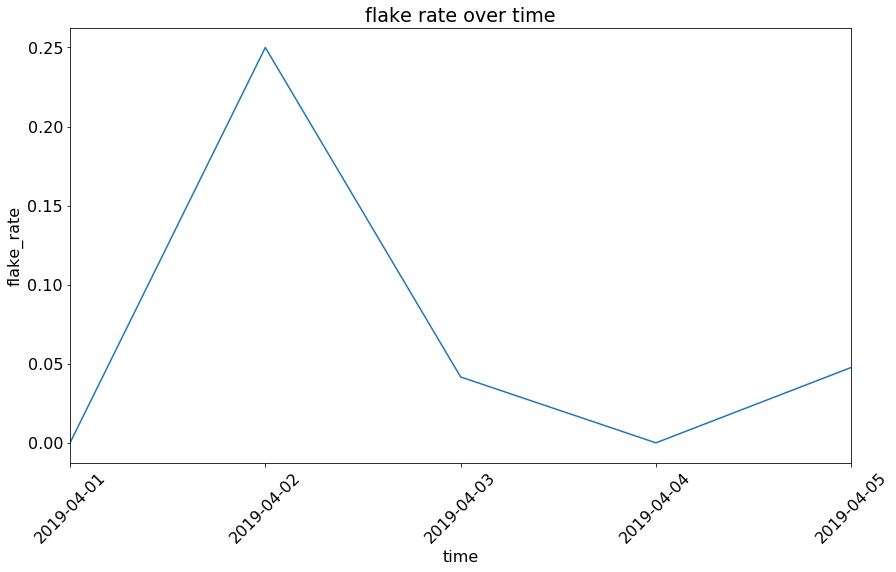

In [33]:
import pandas as pd
overal_flakes = pd.DataFrame(daily_flakiness).groupby("start_date",as_index=False).agg(
{ 'flake_rate':'mean',
  'flakes' :'sum',
   'runs' : 'sum'
})
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
matplotlib.rc('font', size=16)
ax=overal_flakes.flake_rate.plot(xticks=overal_flakes.index,figsize=(14,8), rot=45)
plt.title('flake rate over time')
plt.xlabel('time')
plt.ylabel('flake_rate')
ax.set_xticklabels(overal_flakes['start_date'])

 

plt.show()


# Flakiness per job

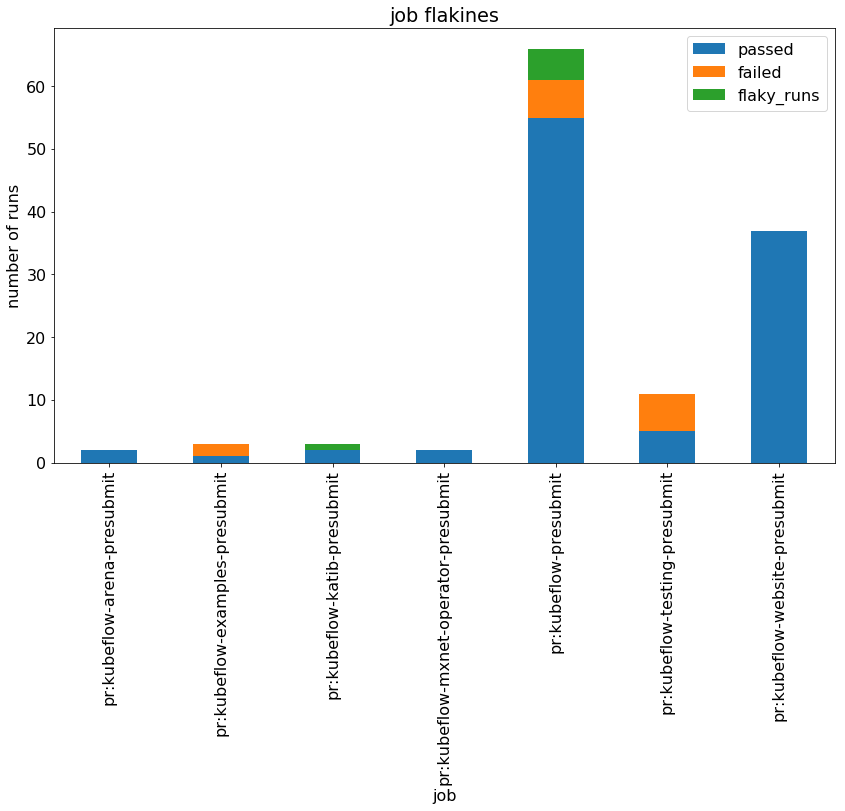

In [34]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

job_flakiness=pd.DataFrame(daily_flakiness).groupby("job",as_index=False).agg(
{ 'passed':'sum',
  'failed' :'sum',
   'flaky_runs' : 'sum'
})
matplotlib.rc('font', size=16)
ax=job_flakiness[['passed','failed','flaky_runs']].plot(kind='bar', stacked=True, xticks=job_flakiness.index, figsize=(14,8), rot=90)
ax.set_xticklabels(job_flakiness['job'])
plt.title('job flakines')
plt.xlabel('job')
plt.ylabel('number of runs')
plt.show()

# Jobs with high flakiness rate


In [35]:
import pandas as pd
pd.DataFrame(daily_flakiness).groupby("job",as_index=False).agg(
{'build_consistency':'mean', 
 'commit_consistency':'mean',
  'flakes' :'sum',
   'runs' : 'sum'
}).sort_values(by=['commit_consistency']).head(20)

,job,commit_consistency,runs,build_consistency,flakes
2,pr:kubeflow-katib-presubmit,0.50000,3,0.7500,1
4,pr:kubeflow-presubmit,0.90175,66,0.9405,5
0,pr:kubeflow-arena-presubmit,1.00000,2,1.0000,0
1,pr:kubeflow-examples-presubmit,1.00000,3,1.0000,0
3,pr:kubeflow-mxnet-operator-presubmit,1.00000,2,1.0000,0
5,pr:kubeflow-testing-presubmit,1.00000,11,1.0000,0
6,pr:kubeflow-website-presubmit,1.00000,37,1.0000,0
